In [1]:
from matplotlib import pyplot as plt
import numpy as np

def SIMULATE_OBSERVER(stim):
    
    true_param = np.array([0, 1, 0.5, 1])
    
    p_next_true = weibull(true_param,stim)
    response = np.random.choice([0, 1], p=[1-p_next_true, p_next_true])

def weibull(param,stim):
    
    logCon = stim[0]
    logSF = stim[1]
    logTH = csf(param,logSF)
    w = 0.1 + 0.9*(1-np.exp(-10**(logCon+logTH)))
    
    return min(0.96,w)

def csf(param,logSF):
    
    import numpy as np
    
    logFmax,logSmax,beta,delta = param[0],param[1],param[2],param[3]
    
    trunc = logSmax-delta
    k = np.log10(2)
    logTH = logSmax - 4*k*(((logSF-logFmax)/(k+beta))**2)
    
    if logSF<logFmax:
        logTH = max(logTH,trunc)

    logTH = max(logTH,0) # >0
    
    return logTH

nSF = 9                             # number of spatial frequencies
nC = 10                             # number of contrast
spatial_frequencies = np.logspace(-1,2,nSF)
contrast = np.logspace(-3,0,nC)
letter_code = ['c','d','h','k','n','o','r','s','v','z']
nTrial = 50                         # number of trials
nPar = 4                            # number of parameters
nVal = 10                           # number of values for each parameter
nSam = 100                          # number of samples (from all param combination)
nVec = nVal**nPar                   # number of all possible param combinations
nStim = nC*nSF                      # number of possible stimuli
stimuli = np.ones((nStim,2))
stimuli[:,0] = np.tile(contrast,nSF)                # contrast
stimuli[:,1] = np.repeat(spatial_frequencies,nC)    # spatial frequency

# 4D param space (log units)
p0a,p0b = -1,2 
p1a,p1b = 0,3 
p2a,p2b = 0,1
p3a,p3b = 0.02,2
param_space = np.ones((nVal,nPar))
param_space[:,0] = np.linspace(p0a,p0b,nVal)    # peak frequency (cpd)
param_space[:,1] = np.linspace(p1a,p1b,nVal)    # peak gain sensitivity (1/contrast)
param_space[:,2] = np.linspace(p2a,p2b,nVal)    # FWHM (cpd)
param_space[:,3] = np.linspace(p3a,p3b,nVal)    # truncation (decades)

# 4D vectors (all possible param combinations)
param_vector = np.ones((nVec,nPar))
for p in range(nPar):
    param_vector[:,p] = np.tile(np.repeat(param_space[:,p],nVal**(nPar-p-1)),nVal**p)
    
# Probability of response (success) to stimulus x, given parameters (theta)... p(failure) = 1-p(success)
psi = np.zeros((nStim,nVec))
for i, param in enumerate(param_vector):
    for j, stim in enumerate(stimuli):
        psi[j,i] = weibull(param,stim)

# Initialize flat prior
prior = np.ones(nVec)/nVec

In [ ]:
for t in range(1):

    ### Select best stimulus
    
    # 0) Sample param space
    ind_sam = np.random.choice(np.arange(nVec), nSam, p=prior)
    psi_sam = psi[:,ind_sam]
    prior_sam = prior[ind_sam]
    
    # 1)
    p_success = np.matmul(psi_sam, prior_sam)
    p_failure = 1-p_success
    
    # 2)
    posterior_success = np.zeros((nStim,nSam))
    posterior_failure = np.zeros((nStim,nSam))
    for i in range(nStim):
        for j in range(nSam):
            posterior_success[i,j] = psi_sam[i,j]*prior_sam[j]/p_success[i]
            posterior_failure[i,j] = (1-psi_sam[i,j])*prior_sam[j]/p_failure[i]
 
    # 3)
    post_entropy_success = np.zeros(nStim)
    post_entropy_failure = np.zeros(nStim) 
    for i in range(nStim):
        post_entropy_success[i] = -sum(posterior_success[i,:]*np.log(posterior_success[i,:]))
        post_entropy_failure[i] = -sum(posterior_failure[i,:]*np.log(posterior_failure[i,:]))
        
    # 4)
    expected_post_entropy = p_success * post_entropy_success + p_failure * post_entropy_failure
    
    # 5)
    best_stim = np.argsort(expected_post_entropy)               # minimize (first values)
    next_stim = best_stim[np.random.randint(round(nStim/10))]   # random pick from top decile
    con_best = stimuli[next_stim,0]
    sf_best = stimuli[next_stim,1]
    correctness = SIMULATE_OBSERVER(stimuli[next_stim,:])
    posterior = np.zeros(nVec)
    
    if correctness:
        for i in range(nVec):
            posterior[i] = psi[next_stim,i]*prior[i]/p_success[next_stim]
    else:
        for i in range(nVec):
            posterior[i] = (1-psi[next_stim,i])*prior[i]/p_failure[next_stim]
            
    prior = posterior/sum(posterior)

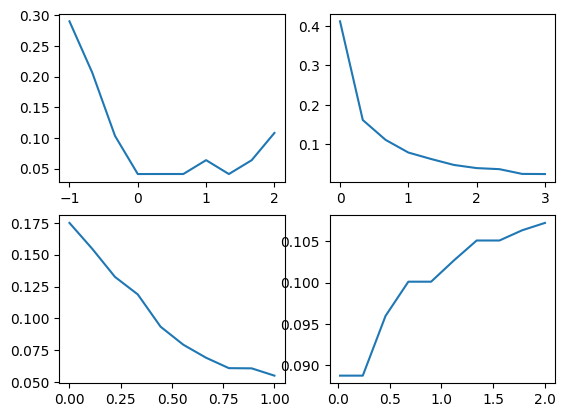

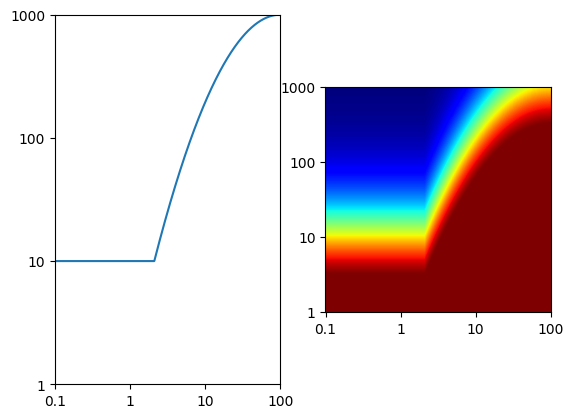

In [16]:
# Marginal probabilities
prob_param = np.zeros((nVal,nPar))
for i in range(nVal):
    for par in range(nPar):
        ind = np.arange(nVec/nVal**(nPar-par-1))
        tmp = np.repeat(ind%nVal,nVal**(nPar-par-1))
        x = np.argwhere(tmp==i)
        prob_param[i,par] = sum(prior[x])
fig,axs = plt.subplots(2,2)
axs[0,0].plot(param_space[:,0],prob_param[:,0])
axs[0,1].plot(param_space[:,1],prob_param[:,1])
axs[1,0].plot(param_space[:,2],prob_param[:,2])
axs[1,1].plot(param_space[:,3],prob_param[:,3])
plt.show()

best_param = sum(prob_param*param_space)

N = 1000
nVec = nVal**nPar
logSF = np.linspace(-1,2,N)
logCon = np.linspace(-3,0,N)
    
# qCSF
fig,ax = plt.subplots(1,2)
logSens = np.ones(N)
for i in range(N):
    logSens[i] = csf(param,logSF[i])
ax[0].plot(logSF,logSens)
ax[0].set_xlim((-1,2))
ax[0].set_ylim((0,3))
ax[0].set_xticks([-1,0,1,2])
ax[0].set_xticklabels(['0.1','1','10','100'])
ax[0].set_yticks([0,1,2,3])
ax[0].set_yticklabels(['1','10','100','1000'])
    
# Probability  density map
prob_density = np.ones([N,N])
for c in range(N):
    for f in range(N):
        prob_density[c,f] = weibull(param,[logCon[c],logSF[f]])
ax[1].imshow(prob_density, cmap='jet')
ax[1].set_xticks([0,333,666,999])
ax[1].set_xticklabels(['0.1','1','10','100'])
ax[1].set_yticks([0,333,666,999])
ax[1].set_yticklabels(['1000','100','10','1'])
plt.show()